# Lab 6: Convolutional Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle 

def load_names(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
    
    label_names = batch['label_names']
    return label_names

def load_data(file):
    with open(file, 'rb') as fl:
        batch = pickle.load(fl, encoding='latin1')
        
    features = batch['data']
    labels = batch['labels']
    return features, labels

batch1, label1 = load_data('data_batch_1')
batch2, label2 = load_data('data_batch_2')
batch3, label3 = load_data('data_batch_3')
batch4, label4 = load_data('data_batch_4')
batch5, label5 = load_data('data_batch_5')
X_test, y_test = load_data('test_batch')
label_names = load_names('batches.meta')

#concatenating files 
X_train = np.concatenate([batch1, batch2, batch3, batch4, batch5], 0)
y_train = np.concatenate([label1, label2, label3, label4, label5], 0)
y_test = np.array(y_test)

In [2]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)


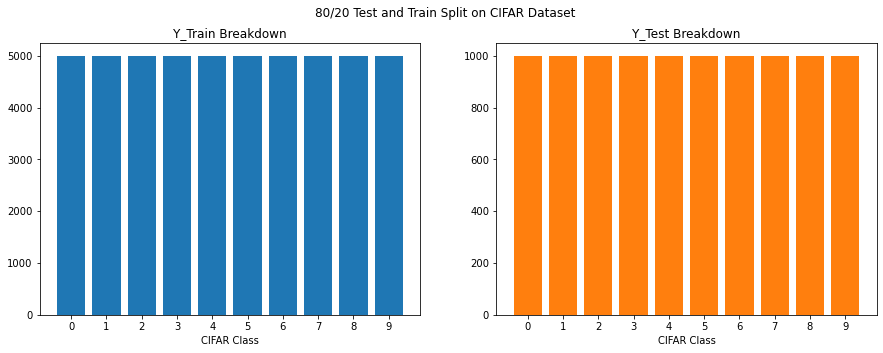

In [3]:
labels = np.arange(10)
train_labels, train_counts =  np.unique(y_train, return_counts=True)
test_labels, test_counts = np.unique(y_test, return_counts=True)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('80/20 Test and Train Split on CIFAR Dataset')
ax1.bar(train_labels,train_counts, color='tab:blue')
ax2.bar(test_labels,test_counts, color='tab:orange')
ax1.set_title('Y_Train Breakdown')
ax2.set_title('Y_Test Breakdown')
ax1.set_xlabel('CIFAR Class')
ax2.set_xlabel('CIFAR Class')
ax1.set_xticks(labels)
ax2.set_xticks(labels)
plt.show()

## Preparation

[1.5 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[1.5 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Modeling

[1.5 points]  Setup the training to use data expansion in Keras (also called data augmentation). Explain why the chosen data expansion techniques are appropriate for your dataset. You can use the keras ImageGenerator as a pre-processing step OR in the optimization loop. You can also use the Keras-cv augmenter (a separate package: https://keras.io/keras_cv/ Links to an external site.)

In [4]:
import tensorflow as tf
from tensorflow import keras 
import sklearn
from sklearn.preprocessing import StandardScaler

## Normalizing Data and Converting to Grayscale

In [5]:
X_train = X_train.reshape((X_train.shape[0],3,32,32))
X_train = X_train.transpose(0,2,3,1)
X_test = X_test.reshape((X_test.shape[0],3,32,32))
X_test = X_test.transpose(0,2,3,1)

X_train = np.dot(X_train,[.2989,.587,.1140])
X_test = np.dot(X_test,[.2989,.587,.1140])

print(np.amin(X_train))
print(np.amax(X_train))

0.0
254.9745


In [7]:
X_train = X_train.reshape((X_train.shape[0],32,32,1))
X_test = X_test.reshape((X_test.shape[0],32,32,1))

instances, height, width, channels = X_train.shape

print('Instances:',instances)
print('Height:', height)
print('Width:', width)
print('Channels:', channels)

Instances: 50000
Height: 32
Width: 32
Channels: 1


In [8]:
#scaler = StandardScaler()

X_train = X_train.reshape((X_train.shape[0],height*width*channels))
X_test = X_test.reshape((X_test.shape[0],height*width*channels))

X_train = X_train.astype('float32')/np.amax(X_train)-0.5
X_test = X_test.astype('float32')/np.amax(X_train)-0.5

#X_train = scaler.fit_transform(X_train.astype('float32'))
#X_test = scaler.transform(X_test.astype('float32'))

X_train = X_train.reshape((X_train.shape[0],height,width,channels))
X_test = X_test.reshape((X_test.shape[0],height,width,channels))

print(X_train.shape)
print(X_test.shape)

(50000, 32, 32, 1)
(10000, 32, 32, 1)


In [9]:
print(np.amin(X_train))
print(np.amax(X_train))

-0.5
0.5


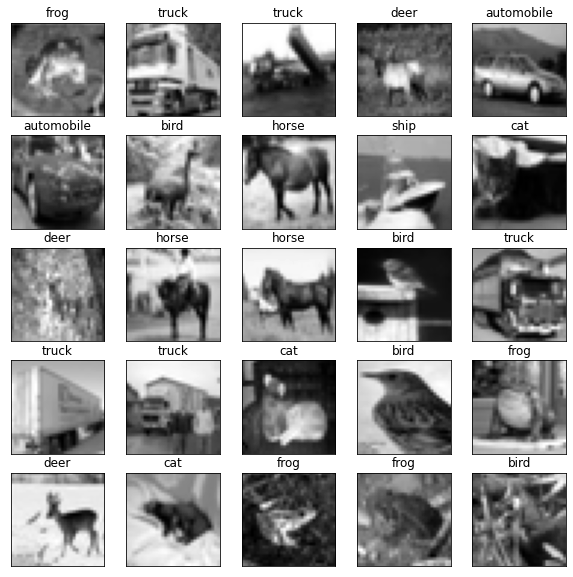

In [11]:
fig = plt.figure(figsize=(10,10))
for i in range(1,26):
    fig.add_subplot(5,5, i)
    plt.imshow(X_train[i-1], cmap=plt.cm.gray)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}'.format(label_names[y_train[i-1]]))

plt.show()

## Data Expansion Using Keras

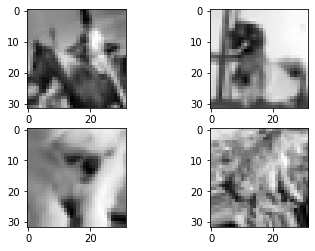

In [13]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=45,
    horizontal_flip=True,
    width_shift_range=3/32,
    height_shift_range=3/32,
    fill_mode='nearest'
    )
datagen.fit(X_train)

#Visualing augmentation
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4, seed=0):
    for i in range(0,4):
        plt.subplot(220+1+i)
        plt.imshow(X_batch[i], cmap=plt.cm.gray)
    plt.show()
    break

## One Hot Encoding of Target Data

In [14]:
num_classes = 10

In [15]:
y_train_hot = keras.utils.to_categorical(y_train, num_classes)
y_test_hot = keras.utils.to_categorical(y_test, num_classes)

## Multi-Layer Perceptron

In [16]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D

In [28]:
%%time
mlp = Sequential()
mlp.add( Flatten() )
mlp.add( Dense(input_dim=1, units=200, activation='relu') )
mlp.add( Dense(units=100, activation='relu') )
mlp.add( Dense(units=50, activation='relu') )
mlp.add( Dense(num_classes) )
mlp.add( Activation('softmax') )

mlp.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 30s 75ms/step - loss: 2.0346 - accuracy: 0.2718 - val_loss: 915.2672 - val_accuracy: 0.1682
Epoch 2/5
390/390 [==============================] - 31s 80ms/step - loss: 1.9400 - accuracy: 0.3081 - val_loss: 1761.5200 - val_accuracy: 0.1519
Epoch 3/5
390/390 [==============================] - 30s 78ms/step - loss: 1.8936 - accuracy: 0.3254 - val_loss: 1226.2498 - val_accuracy: 0.1833
Epoch 4/5
390/390 [==============================] - 33s 84ms/step - loss: 1.8678 - accuracy: 0.3335 - val_loss: 1031.7190 - val_accuracy: 0.2162
Epoch 5/5
390/390 [==============================] - 35s 90ms/step - loss: 1.8394 - accuracy: 0.3453 - val_loss: 842.2874 - val_accuracy: 0.2392
CPU times: total: 15min 38s
Wall time: 2min 40s


In [20]:
print(X_train.shape[1:])

(32, 32, 1)


In [21]:
%%time

cnn1 = Sequential()
cnn1.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn1.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn1.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn1.add(Dropout(0.25))
cnn1.add(Flatten())
cnn1.add(Dense(128,activation='relu'))
cnn1.add(Dropout(0.5))
cnn1.add(Dense(num_classes))
cnn1.add(Activation('softmax'))

cnn1.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn1.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 34s 86ms/step - loss: 1.9581 - accuracy: 0.2932 - val_loss: 526.8848 - val_accuracy: 0.2661
Epoch 2/5
390/390 [==============================] - 35s 90ms/step - loss: 1.7677 - accuracy: 0.3706 - val_loss: 1288.5172 - val_accuracy: 0.1711
Epoch 3/5
390/390 [==============================] - 38s 97ms/step - loss: 1.6778 - accuracy: 0.4018 - val_loss: 948.9258 - val_accuracy: 0.2323
Epoch 4/5
390/390 [==============================] - 40s 101ms/step - loss: 1.6191 - accuracy: 0.4267 - val_loss: 968.0825 - val_accuracy: 0.1704
Epoch 5/5
390/390 [==============================] - 41s 105ms/step - loss: 1.5734 - accuracy: 0.4431 - val_loss: 1320.8392 - val_accuracy: 0.1821
CPU times: total: 21min 10s
Wall time: 3min 8s


In [22]:
%%time

cnn2 = Sequential()
cnn2.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn2.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))

cnn2.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn2.add(Dropout(0.25))
cnn2.add(Flatten())
cnn2.add(Dense(128,activation='relu'))
cnn2.add(Dropout(0.5))
cnn2.add(Dense(num_classes))
cnn2.add(Activation('softmax'))

cnn2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn2.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 77s 195ms/step - loss: 1.9136 - accuracy: 0.3135 - val_loss: 752.2896 - val_accuracy: 0.2445
Epoch 2/5
390/390 [==============================] - 89s 228ms/step - loss: 1.6853 - accuracy: 0.4014 - val_loss: 613.6493 - val_accuracy: 0.2692
Epoch 3/5
390/390 [==============================] - 82s 211ms/step - loss: 1.6003 - accuracy: 0.4340 - val_loss: 773.6144 - val_accuracy: 0.2651
Epoch 4/5
390/390 [==============================] - 79s 202ms/step - loss: 1.5417 - accuracy: 0.4561 - val_loss: 892.6644 - val_accuracy: 0.2516
Epoch 5/5
390/390 [==============================] - 80s 204ms/step - loss: 1.5072 - accuracy: 0.4679 - val_loss: 764.0960 - val_accuracy: 0.2807
CPU times: total: 44min 39s
Wall time: 6min 47s


In [23]:
%%time

cnn3 = Sequential()
cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn3.add(Dropout(0.25))
cnn3.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn3.add(Conv2D(filters=64,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn3.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn3.add(Dropout(0.25))
cnn3.add(Flatten())
cnn3.add(Dense(128,activation='relu'))
cnn3.add(Dropout(0.5))
cnn3.add(Dense(num_classes))
cnn3.add(Activation('softmax'))

cnn3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn3.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 88s 219ms/step - loss: 1.9729 - accuracy: 0.2889 - val_loss: 564.7275 - val_accuracy: 0.2200
Epoch 2/5
390/390 [==============================] - 82s 210ms/step - loss: 1.7009 - accuracy: 0.3930 - val_loss: 570.1873 - val_accuracy: 0.2582
Epoch 3/5
390/390 [==============================] - 92s 236ms/step - loss: 1.5747 - accuracy: 0.4436 - val_loss: 494.6106 - val_accuracy: 0.2254
Epoch 4/5
390/390 [==============================] - 84s 214ms/step - loss: 1.4826 - accuracy: 0.4768 - val_loss: 636.5025 - val_accuracy: 0.1869
Epoch 5/5
390/390 [==============================] - 85s 218ms/step - loss: 1.4138 - accuracy: 0.5054 - val_loss: 424.4354 - val_accuracy: 0.1978
CPU times: total: 48min 8s
Wall time: 7min 12s


In [25]:
%%time

cnn4 = Sequential()
cnn4.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=16,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn4.add(Dropout(0.25))
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',
                data_format='channels_last'))
cnn4.add(Conv2D(filters=32,
                input_shape=X_train.shape[1:],
                kernel_size=(3,3),
                padding='same',
                activation='relu',))
cnn4.add(MaxPooling2D(pool_size=(2,2),
                      data_format='channels_last'))
cnn4.add(Dropout(0.25))
cnn4.add(Flatten())
cnn4.add(Dense(128,activation='relu'))
cnn4.add(Dropout(0.5))
cnn4.add(Dense(num_classes))
cnn4.add(Activation('softmax'))

cnn4.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

cnn4.fit(datagen.flow(X_train, y_train_hot, 
        batch_size=128), steps_per_epoch = len(X_train)/128, epochs=5, 
        shuffle=True, verbose=1, validation_data=(X_test,y_test_hot))

Epoch 1/5
390/390 [==============================] - 47s 117ms/step - loss: 2.0043 - accuracy: 0.2737 - val_loss: 540.1349 - val_accuracy: 0.2109
Epoch 2/5
390/390 [==============================] - 48s 122ms/step - loss: 1.7777 - accuracy: 0.3613 - val_loss: 401.3713 - val_accuracy: 0.2444
Epoch 3/5
390/390 [==============================] - 47s 121ms/step - loss: 1.6618 - accuracy: 0.4069 - val_loss: 655.1699 - val_accuracy: 0.2128
Epoch 4/5
390/390 [==============================] - 51s 131ms/step - loss: 1.5865 - accuracy: 0.4364 - val_loss: 938.3463 - val_accuracy: 0.1744
Epoch 5/5
390/390 [==============================] - 51s 129ms/step - loss: 1.5254 - accuracy: 0.4616 - val_loss: 975.0520 - val_accuracy: 0.2218
CPU times: total: 26min 28s
Wall time: 4min 4s


[2 points] Create a convolutional neural network to use on your data using Keras. Investigate at least two different convolutional network architectures (and investigate changing some parameters of each architecture such as the number of filters--at minimum have two variations of each network for a total of four models trained). Use the method of train/test splitting and evaluation metric that you argued for at the beginning of the lab. Visualize the performance of the training and validation sets per iteration (use the "history" parameter of Keras). Be sure that models converge. 

[1.5 points] Visualize the final results of the CNNs and interpret/compare the performances. Use proper statistics as appropriate, especially for comparing models. 

[1 points] Compare the performance of your convolutional network to a standard multi-layer perceptron (MLP) using the receiver operating characteristic and area under the curve. Use proper statistical comparison techniques.  

## Exceptional Work

Use transfer learning to pre-train the weights of your initial layers of your CNN. Compare the performance when using transfer learning to training without transfer learning (i.e., compare to your best model from above) in terms of classification performance. 